In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np


RANDOM_STATE=12345
RANDOM_SEED=12345

from sklearn.feature_selection import VarianceThreshold, mutual_info_classif as MIC
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier


In [2]:
'''функция для обработки выбросов, 
   заменяем значения лежащие за пределами 3 межквартильных размахов
   на 25-ю персентиль-1.5 межквартильных размаха и на 75-ю персентиль+1.5 межквартильных размаха
      
'''

def outliers(df, c_name):
    u_lim=np.percentile(df[c_name],75)
    l_lim=np.percentile(df[c_name],25)
    iqr=u_lim-l_lim
    
    df.loc[df[c_name]>u_lim+1.5*iqr,c_name]=u_lim+1.5*iqr
    df.loc[df[c_name]<l_lim-1.5*iqr,c_name]=l_lim-1.5*iqr
    
    return df[c_name]
       

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:.3f}'.format

In [4]:
df_2021=pd.read_csv('D:/counterparty-analysis/agents2021.csv')
df_2020=pd.read_csv('D:/counterparty-analysis/agents2020.csv')
df_2019=pd.read_csv('D:/counterparty-analysis/agents2019.csv')

In [5]:
df_2019.head()

,Unnamed: 0,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.","2016, Нематериальные активы, RUB","2017, Нематериальные активы, RUB","2018, Нематериальные активы, RUB","2016, Основные средства , RUB","2017, Основные средства , RUB","2018, Основные средства , RUB","2016, Внеоборотные активы, RUB","2017, Внеоборотные активы, RUB","2018, Внеоборотные активы, RUB","2016, Дебиторская задолженность, RUB","2017, Дебиторская задолженность, RUB","2018, Дебиторская задолженность, RUB","2016, Оборотные активы, RUB","2017, Оборотные активы, RUB","2018, Оборотные активы, RUB","2016, Уставный капитал , RUB","2017, Уставный капитал , RUB","2018, Уставный капитал , RUB","2016, Капитал и резервы, RUB","2017, Капитал и резервы, RUB","2018, Капитал и резервы, RUB","2016, Заёмные средства (долгосрочные), RUB","2017, Заёмные средства (долгосрочные), RUB","2018, Заёмные средства (долгосрочные), RUB","2016, Долгосрочные обязательства, RUB","2017, Долгосрочные обязательства, RUB","2018, Долгосрочные обязательства, RUB","2016, Заёмные средства (краткосрочные), RUB","2017, Заёмные средства (краткосрочные), RUB","2018, Заёмные средства (краткосрочные), RUB","2016, Кредиторская задолженность, RUB","2017, Кредиторская задолженность, RUB","2018, Кредиторская задолженность, RUB","2016, Краткосрочные обязательства, RUB","2017, Краткосрочные обязательства, RUB","2018, Краткосрочные обязательства, RUB","2016, Выручка, RUB","2017, Выручка, RUB","2018, Выручка, RUB","2016, Себестоимость продаж, RUB","2017, Себестоимость продаж, RUB","2018, Себестоимость продаж, RUB","2016, Прибыль (убыток) до налогообложения , RUB","2017, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) до налогообложения , RUB","2016, Прибыль (убыток) от продажи, RUB","2017, Прибыль (убыток) от продажи, RUB","2018, Прибыль (убыток) от продажи, RUB"
0,0,0,0,0.000,0,0.000,0,2895541.401,6245859.873,9050955.414,1889724203.822,1803724203.822,2145239490.446,1928685350.318,1880842038.217,2440077707.006,3583765605.096,3683358598.726,3475461146.497,5159380254.777,5897326114.650,6077447770.701,629400000.000,629400000.000,629400000.000,2673019745.223,2971017197.452,2289273885.350,0.000,0.000,0.000,249877707.006,258973248.408,271221019.108,0.000,0.000,392391719.745,4080056050.955,4452921656.051,5476906369.427,4165168152.866,4548177707.006,5957030573.248,26676980254.777,41626929936.306,37039522292.994,21568144585.987,33354425477.707,34383128662.420,3179696815.287,6167666878.981,746182802.548,3280355414.013,6200119745.223,871619108.280
1,1,1,0,0.000,0,0.000,0,0.000,38853.503,34394.904,144810828.025,148715286.624,152642675.159,145678343.949,149798726.115,153892356.688,55847770.701,46782165.605,156347770.701,148915286.624,189898726.115,291463694.268,1345859.873,1345859.873,1345859.873,272664968.153,277408280.255,310658598.726,0.000,0.000,0.000,3108280.255,4528025.478,5033757.962,9745222.930,47606369.427,63498726.115,9075159.236,10154777.070,66164968.153,18820382.166,57761146.497,129663694.268,255489808.917,257366878.981,543430573.248,205681528.662,205532484.076,416979617.834,12123566.879,6944585.987,44800636.943,16300636.943,11091719.745,51357324.841
2,2,2,7,5.500,1,132825.299,2,2468152.866,12880254.777,8694904.459,969806369.427,944416560.510,928738853.503,973274522.293,1036412101.911,1018682165.605,281467515.924,232107006.369,228049681.529,1286917197.452,1489083439.490,1590216560.510,19644585.987,19644585.987,19644585.987,2110424840.764,2339440127.389,2378698089.172,0.000,0.000,0.000,13398089.172,11831210.191,2843949.045,0.000,0.000,0.000,82468789.809,88571974.522,123771337.580,136368789.809,174224203.822,227356687.898,2786577070.064,2699396815.287,2592420382.166,2038075796.178,2178598089.172,2316724203.822,502666242.038,364422929.936,85529936.306,414858598.726,161131847.134,-92989808.917
3,3,3,0,0.000,0,0.000,0,0.000,0.000,0.000,8

In [6]:
# переименование колонок для единого формата названий
df_2020=df_2020.rename(columns=
     {'Факт. 1':'Факт 1_LY',                                            
    'Факт. 2':'Факт 2_LY',                                         
    'Факт. 3':'Факт 3_LY',                                            
    'Факт. 4': 'Факт 4_LY',                                         
    'Факт. 5':'Факт 5_LY',                                        
    'Факт. 6':'Факт 6_LY',                                             
    'Факт. 7':'Факт 7_LY',                                           
    'Факт. 8':'Факт 8_LY',                                            
    'Факт. 9':'Факт 9_LY',                                         
   'Факт. 10':'Факт 10_LY',                                         
   'Факт. 11':'Факт 11_LY',                                        
   'Факт. 12':'Факт 12_LY',                                           
   'Факт. 13':'Факт 13_LY',                                         
   'Факт. 14':'Факт 14_LY',                                       
   'Факт. 15':'Факт 15_LY',                                          
   'Факт. 16':'Факт 16_LY',                                           
   'Факт. 17':'Факт 17_LY',                                        
   'Факт. 18':'Факт 18_LY',                                           
   'Факт. 19':'Факт 19_LY',                                         
   'Факт. 20':'Факт 20_LY',                                           
   'Факт. 21':'Факт 21_LY',                                          
   'Факт. 22':'Факт 22_LY',                                          
   'Факт. 23':'Факт 23_LY',                                        
   'Факт. 24':'Факт 24_LY',                                        
   'Факт. 25':'Факт 25_LY',                                           
   'Факт. 26':'Факт 26_LY',                                          
   'Факт. 27':'Факт 27_LY',                                            
   'Факт. 28':'Факт 28_LY',                                        
   'Факт. 29':'Факт 29_LY',                                         
   'Факт. 30':'Факт 30_LY',                                           
   'Факт. 31':'Факт 31_LY',                                         
   'Факт. 32':'Факт 32_LY',                                        
   'Факт. 33':'Факт 33_LY',                                          
   'Факт. 34':'Факт 34_LY',                                            
   'Факт. 35':'Факт 35_LY',                                           
   'Факт. 36':'Факт 36_LY',                                           
   'Факт. 37':'Факт 37_LY',                                          
   'Факт. 38':'Факт 38_LY',                                          
   'Факт. 39':'Факт 39_LY',                                            
   'Факт. 40':'Факт 40_LY',                                            
   'Факт. 41':'Факт 41_LY',                                         
   'Факт. 42':'Факт 42_LY',                                            
   'Факт. 43':'Факт 43_LY',                                         
   'Факт. 44':'Факт 44_LY',                                         
   'Факт. 45':'Факт 45_LY',                                          
   'Факт. 46':'Факт 46_LY',                                           
   'Факт. 47':'Факт 47_LY',                                          
   'Факт. 48':'Факт 48_LY',                                          
   'Факт. 49':'Факт 49_LY',                                           
   'Факт. 50':'Факт 50_LY',                                        
   'Факт. 51':'Факт 51_LY',                                          
   'Факт. 52':'Факт 52_LY',                                         
   'Факт. 53':'Факт 53_LY',                                           
   'Факт. 54':'Факт 54_LY',                                          
   'Факт. 55':'Факт 55_LY',                                        
   'Факт. 56':'Факт 56_LY',                                         
   'Факт. 57':'Факт 57_LY',                                         
   'Факт. 58':'Факт 58_LY',                                        
   'Факт. 59':'Факт 59_LY',                                       
   'Факт. 60':'Факт 60_LY'}   

)

In [7]:
#здесь хранятся данные по весам Фактов за 2020й год
tmp_df=df_2020[[
    'Наименование ДП',
    'Факт 1_LY',                                            
    'Факт 2_LY',                                         
    'Факт 3_LY',                                            
    'Факт 4_LY',                                         
    'Факт 5_LY',                                        
    'Факт 6_LY',                                             
    'Факт 7_LY',                                           
    'Факт 8_LY',                                            
    'Факт 9_LY',                                         
   'Факт 10_LY',                                         
   'Факт 11_LY',                                        
   'Факт 12_LY',                                           
   'Факт 13_LY',                                         
   'Факт 14_LY',                                       
   'Факт 15_LY',                                          
   'Факт 16_LY',                                           
   'Факт 17_LY',                                        
   'Факт 18_LY',                                           
   'Факт 19_LY',                                         
   'Факт 20_LY',                                           
   'Факт 21_LY',                                          
   'Факт 22_LY',                                          
   'Факт 23_LY',                                        
   'Факт 24_LY',                                        
   'Факт 25_LY',                                           
   'Факт 26_LY',                                          
   'Факт 27_LY',                                            
   'Факт 28_LY',                                        
   'Факт 29_LY',                                         
   'Факт 30_LY',                                           
   'Факт 31_LY',                                         
   'Факт 32_LY',                                        
   'Факт 33_LY',                                          
   'Факт 34_LY',                                            
   'Факт 35_LY',                                           
   'Факт 36_LY',                                           
   'Факт 37_LY',                                          
   'Факт 38_LY',                                          
   'Факт 39_LY',                                            
   'Факт 40_LY',                                            
   'Факт 41_LY',                                         
   'Факт 42_LY',                                            
   'Факт 43_LY',                                         
   'Факт 44_LY',                                         
   'Факт 45_LY',                                          
   'Факт 46_LY',                                           
   'Факт 47_LY',                                          
   'Факт 48_LY',                                          
   'Факт 49_LY',                                           
   'Факт 50_LY',                                        
   'Факт 51_LY',                                          
   'Факт 52_LY',                                         
   'Факт 53_LY',                                           
   'Факт 54_LY',                                          
   'Факт 55_LY',                                        
   'Факт 56_LY',                                         
   'Факт 57_LY',                                         
   'Факт 58_LY',                                        
   'Факт 59_LY',                                       
   'Факт 60_LY'
        
]]

In [8]:
df_2021.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 136 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   Unnamed: 0                                         int64  
 1   Наименование ДП                                    int64  
 2   Макс. ПДЗ за 2019 год, дней                        int64  
 3   Сред. ПДЗ за 2019 год, дней                        float64
 4   Кол-во просрочек свыше 5-ти дней за 2019 год, шт.  int64  
 5   Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.  float64
 6   Кол-во раз ПДЗ за 2019 год, шт.                    int64  
 7   Макс. ПДЗ за 2020 год, дней                        int64  
 8   Сред. ПДЗ за 2020 год, дней                        float64
 9   Кол-во просрочек свыше 5-ти дней за 2020 год, шт.  int64  
 10  Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.  float64
 11  Кол-во раз ПДЗ за 2020 год, шт.                    int64 

In [9]:
df_2021=df_2021.rename(columns={
    'Факт. 20':'Факт 20',                                        
   'Факт. 21':'Факт 21',                                         
   'Факт.32':'Факт 32',                                          
   'Факт.31':'Факт 31',                                           
    'Факт.23':'Факт 23'                                             
})

In [10]:
# добавим данные по весам Фактов за прошлый год
total_df=pd.merge(df_2021,tmp_df,on='Наименование ДП', how='left')

In [11]:
# первым целевым признаком будет сам факт возниктовения задолженности
total_df['TARGET']=total_df[['ПДЗ 1-30','ПДЗ 31-90','ПДЗ 91-365','ПДЗ более 365']].max(axis=1)

In [12]:
# наименование плательщика удалим, для расчетов оно бесполезно
# также удалим данные по суммарному весу всех Фактов
total_df=total_df.drop(['Наименование ДП','Итого','Unnamed: 0'], axis=1)

In [13]:
#заменим все пропуски нулями
total_df=total_df.replace('Х',0)
total_df=total_df.replace('Н/Д',0)
total_df=total_df.fillna(0)

In [14]:
target_columns=['TARGET','ПДЗ 1-30','ПДЗ 31-90','ПДЗ 91-365','ПДЗ более 365']

In [15]:
# вторым целевым признаком для нас будет тип задолженности:
#1:'ПДЗ 1-30'
#2:'ПДЗ 31-90'
#3:'ПДЗ 91-365'
#4:'ПДЗ более 365'
total_df['МАКС_ПДЗ_2021']=total_df.apply(lambda x: max(x['ПДЗ 1-30']*1,x['ПДЗ 31-90']*2,x['ПДЗ 91-365']*3,x['ПДЗ более 365']*4), axis = 1)

In [16]:
total_df.describe().T

,count,mean,std,min,25%,50%,75%,max
"Макс. ПДЗ за 2019 год, дней",325.000,39.114,140.921,0.000,0.000,4.000,14.000,884.000
"Сред. ПДЗ за 2019 год, дней",325.000,9.553,39.348,0.000,0.000,2.111,5.134,608.000
"Кол-во просрочек свыше 5-ти дней за 2019 год, шт.",325.000,8.403,26.542,0.000,0.000,0.000,4.000,288.000
"Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.",325.000,6279812.531,22116136.539,0.000,0.000,0.000,1757411.758,247713804.357
"Кол-во раз ПДЗ за 2019 год, шт.",325.000,22.729,53.518,0.000,0.000,2.000,19.000,451.000
"Макс. ПДЗ за 2020 год, дней",325.000,32.618,79.206,0.000,1.000,7.000,21.000,489.000
"Сред. ПДЗ за 2020 год, дней",325.000,10.163,28.782,0.000,1.000,3.000,6.275,245.216
"Кол-во просрочек свыше 5-ти дней за 2020 год, шт.",325.000,12.692,39.190,0.000,0.000,1.000,9.000,445.000
"Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.",325.000,8879592.441,27974958.759,0.000,0.000,72737.350,4264366.611,271633129.987
"Кол-во раз ПДЗ за 2020 год, шт.",325.000,32.351,65.243,0.000,1.000,8.000,36.000,478.000


In [17]:
#заменим статусы на числовые значения
dict_1={'Действующая':1,'В состоянии банкротства':2}
total_df['Статус']=total_df['Статус'].map(dict_1)

In [18]:
# преобразуем столбцы в тип float
for c in total_df.columns:
    total_df[c]=total_df[c].astype('float32')

In [19]:
# обработаем аномалии
f_list=[
        'Макс. ПДЗ за 2019 год, дней',                      
        'Сред. ПДЗ за 2019 год, дней',                        
       'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',  
       'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.',  
   'Кол-во раз ПДЗ за 2019 год, шт.',                     
   'Макс. ПДЗ за 2020 год, дней',                        
   'Сред. ПДЗ за 2020 год, дней' ,                       
   'Кол-во просрочек свыше 5-ти дней за 2020 год, шт.',   
   'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.',  
   'Кол-во раз ПДЗ за 2020 год, шт.'  ,      
   'Оценка потенциала контрагента 1, руб.',              
   'Оценка потенциала контрагента 2, руб.',                                                        
   '2016, Нематериальные активы, RUB',                   
   '2017, Нематериальные активы, RUB',                   
   '2018, Нематериальные активы, RUB',                   
   '2019, Нематериальные активы, RUB',                   
   '2020, Нематериальные активы, RUB',                  
   '2016, Основные средства , RUB',                      
   '2017, Основные средства , RUB',                      
   '2018, Основные средства , RUB',                      
  '2019, Основные средства , RUB',                      
  '2020, Основные средства , RUB',                      
  '2016, Внеоборотные активы, RUB',                     
  '2017, Внеоборотные активы, RUB',                     
   '2018, Внеоборотные активы, RUB',                     
   '2019, Внеоборотные активы, RUB',                     
   '2020, Внеоборотные активы, RUB',                     
   '2016, Дебиторская задолженность, RUB',               
  '2017, Дебиторская задолженность, RUB',               
 '2018, Дебиторская задолженность, RUB',               
   '2019, Дебиторская задолженность, RUB',               
  '2020, Дебиторская задолженность, RUB',               
  '2016, Оборотные активы, RUB',                       
  '2017, Оборотные активы, RUB',                      
  '2018, Оборотные активы, RUB',                        
  '2019, Оборотные активы, RUB',                        
   '2020, Оборотные активы, RUB',                      
  '2016, Уставный капитал , RUB',                       
   '2017, Уставный капитал , RUB',                       
   '2018, Уставный капитал , RUB',                       
  '2019, Уставный капитал , RUB',                       
   '2020, Уставный капитал , RUB',                       
  '2016, Капитал и резервы, RUB',                       
  '2017, Капитал и резервы, RUB' ,                      
   '2018, Капитал и резервы, RUB',                      
  '2019, Капитал и резервы, RUB' ,                      
   '2020, Капитал и резервы, RUB',                       
  '2016, Заёмные средства (долгосрочные), RUB',         
  '2017, Заёмные средства (долгосрочные), RUB',         
   '2018, Заёмные средства (долгосрочные), RUB',         
  '2019, Заёмные средства (долгосрочные), RUB' ,        
   '2020, Заёмные средства (долгосрочные), RUB',         
   '2016, Долгосрочные обязательства, RUB',              
   '2017, Долгосрочные обязательства, RUB',              
   '2018, Долгосрочные обязательства, RUB',              
   '2019, Долгосрочные обязательства, RUB',              
   '2020, Долгосрочные обязательства, RUB',              
  '2016, Заёмные средства (краткосрочные), RUB',        
  '2017, Заёмные средства (краткосрочные), RUB',        
   '2018, Заёмные средства (краткосрочные), RUB',        
    '2019, Заёмные средства (краткосрочные), RUB',        
   '2020, Заёмные средства (краткосрочные), RUB',       
   '2016, Кредиторская задолженность, RUB',              
  '2017, Кредиторская задолженность, RUB',              
  '2018, Кредиторская задолженность, RUB',              
  '2019, Кредиторская задолженность, RUB' ,             
   '2020, Кредиторская задолженность, RUB',              
    '2016, Краткосрочные обязательства, RUB' ,            
   '2017, Краткосрочные обязательства, RUB',             
   '2018, Краткосрочные обязательства, RUB',             
   '2019, Краткосрочные обязательства, RUB',             
  '2020, Краткосрочные обязательства, RUB',             
   '2016, Выручка, RUB',                                 
   '2017, Выручка, RUB',                                 
  '2018, Выручка, RUB',                                 
    '2019, Выручка, RUB',                                 
    '2020, Выручка, RUB',                                 
  '2016, Себестоимость продаж, RUB',                    
    '2017, Себестоимость продаж, RUB',                    
   '2018, Себестоимость продаж, RUB',                    
   '2019, Себестоимость продаж, RUB',                    
   '2020, Себестоимость продаж, RUB',                    
   '2016, Прибыль (убыток) до налогообложения , RUB',    
   '2017, Прибыль (убыток) до налогообложения , RUB',    
   '2018, Прибыль (убыток) до налогообложения , RUB',    
  '2019, Прибыль (убыток) до налогообложения , RUB' ,   
   '2020, Прибыль (убыток) до налогообложения , RUB',    
  '2016, Прибыль (убыток) от продажи, RUB',             
   '2017, Прибыль (убыток) от продажи, RUB',            
  '2018, Прибыль (убыток) от продажи, RUB' ,            
  '2019, Прибыль (убыток) от продажи, RUB' ,           
  '2020, Прибыль (убыток) от продажи, RUB'     
  ]
    
    
for c in f_list:
    total_df[c]=outliers(total_df,c)

In [20]:
# удалим целевые колонки и оставим только независимые переменные
features=total_df.drop('МАКС_ПДЗ_2021', axis=1)
features=features.drop(target_columns, axis=1)
features_new=features.copy(deep=True)

In [21]:
# целевая переменная
target=total_df['TARGET']

In [22]:
features_train, features_test, target_train, target_test=train_test_split(features, target, test_size=.2,random_state=RANDOM_STATE)
features_train_new, features_test_new, target_train_new, target_test_new=train_test_split(features_new, target, test_size=.2,random_state=RANDOM_STATE)

In [23]:
'''
В функции ниже будут создаваться новые признаки, т.к. отдельно смотреть на каждый признак смысла нет, 
 выручка ничего не скажет о компании без прибыли и т.д.
 
Здесь мы пытались создать новые признаки для оценки ликвидности, активов, пассивов, динамики по годам для новых клиентов

'''
def make_features(df):
    f_list=[                                                           
   '2016, Нематериальные активы, RUB',                   
   '2017, Нематериальные активы, RUB',                   
   '2018, Нематериальные активы, RUB',                   
   '2019, Нематериальные активы, RUB',                   
   '2020, Нематериальные активы, RUB',                  
   '2016, Основные средства , RUB',                      
   '2017, Основные средства , RUB',                      
   '2018, Основные средства , RUB',                      
  '2019, Основные средства , RUB',                      
  '2020, Основные средства , RUB',                      
  '2016, Внеоборотные активы, RUB',                     
  '2017, Внеоборотные активы, RUB',                     
   '2018, Внеоборотные активы, RUB',                     
   '2019, Внеоборотные активы, RUB',                     
   '2020, Внеоборотные активы, RUB',                     
   '2016, Дебиторская задолженность, RUB',               
  '2017, Дебиторская задолженность, RUB',               
  '2018, Дебиторская задолженность, RUB',               
   '2019, Дебиторская задолженность, RUB',               
  '2020, Дебиторская задолженность, RUB',               
  '2016, Оборотные активы, RUB',                       
  '2017, Оборотные активы, RUB',                      
  '2018, Оборотные активы, RUB',                        
  '2019, Оборотные активы, RUB',                        
   '2020, Оборотные активы, RUB',                      
  '2016, Уставный капитал , RUB',                       
   '2017, Уставный капитал , RUB',                       
   '2018, Уставный капитал , RUB',                       
  '2019, Уставный капитал , RUB',                       
   '2020, Уставный капитал , RUB',                       
  '2016, Капитал и резервы, RUB',                       
  '2017, Капитал и резервы, RUB' ,                      
   '2018, Капитал и резервы, RUB',                      
  '2019, Капитал и резервы, RUB' ,                      
   '2020, Капитал и резервы, RUB',                       
  '2016, Заёмные средства (долгосрочные), RUB',         
  '2017, Заёмные средства (долгосрочные), RUB',         
   '2018, Заёмные средства (долгосрочные), RUB',         
  '2019, Заёмные средства (долгосрочные), RUB' ,        
   '2020, Заёмные средства (долгосрочные), RUB',         
   '2016, Долгосрочные обязательства, RUB',              
   '2017, Долгосрочные обязательства, RUB',              
   '2018, Долгосрочные обязательства, RUB',              
   '2019, Долгосрочные обязательства, RUB',              
   '2020, Долгосрочные обязательства, RUB',              
  '2016, Заёмные средства (краткосрочные), RUB',        
  '2017, Заёмные средства (краткосрочные), RUB',        
   '2018, Заёмные средства (краткосрочные), RUB',        
    '2019, Заёмные средства (краткосрочные), RUB',        
   '2020, Заёмные средства (краткосрочные), RUB',       
   '2016, Кредиторская задолженность, RUB',              
  '2017, Кредиторская задолженность, RUB',              
  '2018, Кредиторская задолженность, RUB',              
  '2019, Кредиторская задолженность, RUB' ,             
   '2020, Кредиторская задолженность, RUB',              
    '2016, Краткосрочные обязательства, RUB' ,            
   '2017, Краткосрочные обязательства, RUB',             
   '2018, Краткосрочные обязательства, RUB',             
   '2019, Краткосрочные обязательства, RUB',             
  '2020, Краткосрочные обязательства, RUB',             
   '2016, Выручка, RUB', 
   '2017, Выручка, RUB',                                 
  '2018, Выручка, RUB',                                 
    '2019, Выручка, RUB',                                 
    '2020, Выручка, RUB',                                 
  '2016, Себестоимость продаж, RUB',                    
    '2017, Себестоимость продаж, RUB',                    
   '2018, Себестоимость продаж, RUB',                    
   '2019, Себестоимость продаж, RUB',                    
   '2020, Себестоимость продаж, RUB',                    
   '2016, Прибыль (убыток) до налогообложения , RUB',    
   '2017, Прибыль (убыток) до налогообложения , RUB',    
   '2018, Прибыль (убыток) до налогообложения , RUB',    
  '2019, Прибыль (убыток) до налогообложения , RUB' ,   
   '2020, Прибыль (убыток) до налогообложения , RUB',    
  '2016, Прибыль (убыток) от продажи, RUB',             
   '2017, Прибыль (убыток) от продажи, RUB',            
  '2018, Прибыль (убыток) от продажи, RUB' ,            
  '2019, Прибыль (убыток) от продажи, RUB' ,           
  '2020, Прибыль (убыток) от продажи, RUB'     
  ]
  
    feat_dict=[
    'Нематериальные активы, RUB',                                      
    'Основные средства , RUB',                                        
     'Внеоборотные активы, RUB',                                   
   'Дебиторская задолженность, RUB',                  
  'Оборотные активы, RUB',                                         
  'Уставный капитал , RUB',                                          
  'Капитал и резервы, RUB',                                              
  'Заёмные средства (долгосрочные), RUB',               
   'Долгосрочные обязательства, RUB',                       
  'Заёмные средства (краткосрочные), RUB',              
   'Кредиторская задолженность, RUB',                       
    'Краткосрочные обязательства, RUB' ,                     
   'Выручка, RUB',                                                    
  'Себестоимость продаж, RUB',                      
   'Прибыль (убыток) до налогообложения , RUB',    
    'Прибыль (убыток) от продажи, RUB'                
]
    
    fact_list=[]
    
    for f in df.columns:
        if 'Факт' in f: fact_list.append(f)
    
    df=df.drop(fact_list, axis=1)
    
    
    pdz_dict=[
           'Оценка потенциала контрагента 1, руб.',              
   'Оценка потенциала контрагента 2, руб.',
        'Макс. ПДЗ за 2019 год, дней',                      
        'Сред. ПДЗ за 2019 год, дней',                        
       'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',  
       'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.',  
   'Кол-во раз ПДЗ за 2019 год, шт.',                     
   'Макс. ПДЗ за 2020 год, дней',                        
   'Сред. ПДЗ за 2020 год, дней' ,                       
   'Кол-во просрочек свыше 5-ти дней за 2020 год, шт.',   
   'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.',  
   'Кол-во раз ПДЗ за 2020 год, шт.'                  
    ]
    
    df=df.drop(pdz_dict, axis=1)


    df_columns_names=df.columns

    # рентабельность:     
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Рентабельность,%']=np.where((df[y+', Капитал и резервы, RUB']+df[y+', Долгосрочные обязательства, RUB'])>0,
                                          df[y+', Прибыль (убыток) до налогообложения , RUB']
                                          /(df[y+', Капитал и резервы, RUB']+df[y+', Долгосрочные обязательства, RUB']),
                                          -1)
    


    dict_1={'Нематериальные активы, RUB','Основные средства , RUB','Внеоборотные активы, RUB'}
    dict_2={'Дебиторская задолженность, RUB','Оборотные активы, RUB'}
    #активы dict_1+dict_2
    dict_3={'Уставный капитал , RUB','Капитал и резервы, RUB'}
    dict_4={'Заёмные средства (долгосрочные), RUB','Долгосрочные обязательства, RUB'}
    dict_5={'Заёмные средства (краткосрочные), RUB','Краткосрочные обязательства, RUB','Кредиторская задолженность, RUB'}
    # пассивы dict_3+...+dict_5

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Внеоборотные_активы, руб.']=0
        for act in dict_1:
            df[y+'_Итого_Внеоборотные_активы, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Оборотные_активы, руб.']=0
        for act in dict_2:
            df[y+'_Итого_Оборотные_активы, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']=0
        for act in dict_3:
            df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Долгосрочные_Обязательства, руб.']=0      
        for act in dict_4:
            df[y+'_Итого_Долгосрочные_Обязательства, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Краткосрочные_Обязательства, руб.']=0
        for act in dict_5:
            df[y+'_Итого_Краткосрочные_Обязательства, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Хорошие_Активы, руб.']=(df[y+'_Итого_Внеоборотные_активы, руб.']+
                                               df[y+'_Итого_Оборотные_активы, руб.']+
                                               df[y+', Выручка, RUB']+
                                               df[y+', Прибыль (убыток) до налогообложения , RUB']                                                                                                                                          
                                              )

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Плохие_Активы, руб.']=(df[y+'_Итого_Долгосрочные_Обязательства, руб.']+
                                              df[y+'_Итого_Краткосрочные_Обязательства, руб.']                                                                                                                                          
                                              )

            
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Хорошие_Плохие']=np.where(df[y+'_Итого_Плохие_Активы, руб.']>0,
                                        df[y+'_Итого_Хорошие_Активы, руб.']/df[y+'_Итого_Плохие_Активы, руб.'],
                                        1)

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Активы, руб.']=df[y+'_Итого_Внеоборотные_активы, руб.']+df[y+'_Итого_Оборотные_активы, руб.']

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Пассивы, руб.']=df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']+df[y+'_Итого_Краткосрочные_Обязательства, руб.']

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Активы_Пассивы']=np.where((df[y+'_Итого_Пассивы, руб.']+df[y+'_Итого_Активы, руб.'])>0,
                                        df[y+'_Итого_Активы, руб.']/(df[y+'_Итого_Пассивы, руб.']+df[y+'_Итого_Активы, руб.']),
                                        -100)

    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Капитал_Пассивы']=np.where(df[y+'_Итого_Пассивы, руб.']>0,df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']/df[y+'_Итого_Пассивы, руб.'],-10)

   # for y in ['2016','2017','2018','2019','2020']:
   #     df[y+'Активы_Пассивы_1']=np.where(df[y+'_Итого_Пассивы, руб.']>0,df[y+'_Итого_Активы, руб.']/df[y+'_Итого_Пассивы, руб.'],-1)
        
        
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Обязательства, RUB']=df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Выручка_vs_Обязательства, %']=(np.where(df[y+', Выручка, RUB']>0,
                                             df[y+', Прибыль (убыток) от продажи, RUB']/df[y+', Выручка, RUB'],-1)   
                                            )
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Капитал_vs_активы, %']=(np.where(df[y+'_Итого_Оборотные_активы, руб.']>0,
                                             (df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']-df[y+'_Итого_Внеоборотные_активы, руб.'])/df[y+'_Итого_Оборотные_активы, руб.'],-1)   
                                            )
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Рентабельность капитала, %']=(np.where(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']>0,
                                             df[y+', Прибыль (убыток) от продажи, RUB']/df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.'],-1)   
                                            )
    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Приход, RUB']=(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+df[y+', Себестоимость продаж, RUB']+df[y+', Выручка, RUB']
                            +df[y+', Прибыль (убыток) до налогообложения , RUB'])
        
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Pасход, RUB']=(df[y+', Дебиторская задолженность, RUB']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']
                            +df[y+'_Итого_Краткосрочные_Обязательства, руб.'])
    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Приход_Расход, %']=np.where(df[y+'Pасход, RUB']>0,
                                         df[y+'Приход, RUB']/df[y+'Pасход, RUB'],-1)
    
 
    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'КТЛ, %']=np.where((df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.'])>0,
                                         df[y+'_Итого_Оборотные_активы, руб.']/(df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']),-10)
        
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'КФР, %']=np.where((df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.'])>0,
                                         (df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.'])/(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']),-10)
      
    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'К-т Альтмана']=-0.3877-1.0736*df[y+'КТЛ, %']+0.579*df[y+'КФР, %']  
            
    
    new_feat=['_Итого_Внеоборотные_активы, руб.','_Итого_Оборотные_активы, руб.',
              '_Итого_Капитал_РЕЗЕРВЫ, руб.','_Итого_Долгосрочные_Обязательства, руб.',
             '_Итого_Краткосрочные_Обязательства, руб.','_Итого_Активы, руб.',
              '_Итого_Пассивы, руб.','Активы_Пассивы','Капитал_Пассивы',
              'Активы_Пассивы_1','Обязательства, RUB', 'Выручка_vs_Обязательства, %',
              'Капитал_vs_активы, %',
              'Рентабельность капитала, %',
              'Приход, RUB',
              'Pасход, RUB',
              'Приход_Расход, %',
              'КФР, %',
              'КТЛ, %',
              'К-т Альтмана'                                                        
             ]
                        

  # добавим средние показатели за весь период, средние за 2016-2018 и средние за 2019-2020
        
    for s_str in feat_dict:
        for column in df_columns_names:
            if s_str in column:
                df['DELTA_'+s_str]=df['2020, '+s_str]-df['2016, '+s_str]

    for s_str in feat_dict:
        df['AV_'+s_str]=0
        for y in ['2016','2017','2018','2019','2020']:
            df['AV_'+s_str]+=df[y+', '+s_str]
        df['AV_'+s_str]=df['AV_'+s_str]/5

    for s_str in feat_dict:
        df['16-18_AV_'+s_str]=0
        for y in ['2016','2017','2018']:
            df['AV_'+s_str]+=df[y+', '+s_str]
        df['AV_'+s_str]=df['AV_'+s_str]/3

    for s_str in feat_dict:
        df['19-20_AV_'+s_str]=0
        for y in ['2019','2020']:
            df['AV_'+s_str]+=df[y+', '+s_str]
        df['AV_'+s_str]=df['AV_'+s_str]/2
        
    

   # 2020/2019 Основные показатели
    
    for s_str in feat_dict:
        for column in df_columns_names:
            if s_str in column:
                df['DELTA_20-19_'+s_str]=df['2020, '+s_str]-df['2019, '+s_str]


    df=df.drop(f_list, axis=1)

         
    return df


In [24]:
'''
Здесь мы делаем признаки для существующих клиентов

'''
def make_features_current_clients(df):
    f_list=[                                                           
   '2016, Нематериальные активы, RUB', '2017, Нематериальные активы, RUB', '2018, Нематериальные активы, RUB',                   
   '2019, Нематериальные активы, RUB', '2020, Нематериальные активы, RUB',                  
   '2016, Основные средства , RUB', '2017, Основные средства , RUB',                      
   '2018, Основные средства , RUB', '2019, Основные средства , RUB',                      
  '2020, Основные средства , RUB','2016, Внеоборотные активы, RUB',                     
  '2017, Внеоборотные активы, RUB', '2018, Внеоборотные активы, RUB',                     
   '2019, Внеоборотные активы, RUB', '2020, Внеоборотные активы, RUB',                     
   '2016, Дебиторская задолженность, RUB','2017, Дебиторская задолженность, RUB',               
 '2018, Дебиторская задолженность, RUB', '2019, Дебиторская задолженность, RUB',               
  '2020, Дебиторская задолженность, RUB', '2016, Оборотные активы, RUB',                       
  '2017, Оборотные активы, RUB', '2018, Оборотные активы, RUB',                        
  '2019, Оборотные активы, RUB', '2020, Оборотные активы, RUB',                      
  '2016, Уставный капитал , RUB', '2017, Уставный капитал , RUB',                       
   '2018, Уставный капитал , RUB', '2019, Уставный капитал , RUB',                       
   '2020, Уставный капитал , RUB', '2016, Капитал и резервы, RUB',                       
  '2017, Капитал и резервы, RUB' , '2018, Капитал и резервы, RUB',                      
  '2019, Капитал и резервы, RUB' ,  '2020, Капитал и резервы, RUB',                       
  '2016, Заёмные средства (долгосрочные), RUB','2017, Заёмные средства (долгосрочные), RUB',         
   '2018, Заёмные средства (долгосрочные), RUB', '2019, Заёмные средства (долгосрочные), RUB' ,        
   '2020, Заёмные средства (долгосрочные), RUB', '2016, Долгосрочные обязательства, RUB',              
   '2017, Долгосрочные обязательства, RUB', '2018, Долгосрочные обязательства, RUB',              
   '2019, Долгосрочные обязательства, RUB','2020, Долгосрочные обязательства, RUB',              
  '2016, Заёмные средства (краткосрочные), RUB', '2017, Заёмные средства (краткосрочные), RUB',        
   '2018, Заёмные средства (краткосрочные), RUB','2019, Заёмные средства (краткосрочные), RUB',        
   '2020, Заёмные средства (краткосрочные), RUB', '2016, Кредиторская задолженность, RUB',              
  '2017, Кредиторская задолженность, RUB', '2018, Кредиторская задолженность, RUB',              
  '2019, Кредиторская задолженность, RUB' , '2020, Кредиторская задолженность, RUB',              
    '2016, Краткосрочные обязательства, RUB' , '2017, Краткосрочные обязательства, RUB',             
   '2018, Краткосрочные обязательства, RUB','2019, Краткосрочные обязательства, RUB',             
  '2020, Краткосрочные обязательства, RUB', '2016, Выручка, RUB', 
   '2017, Выручка, RUB', '2018, Выручка, RUB',                                 
    '2019, Выручка, RUB','2020, Выручка, RUB',                                 
  '2016, Себестоимость продаж, RUB', '2017, Себестоимость продаж, RUB',                    
   '2018, Себестоимость продаж, RUB', '2019, Себестоимость продаж, RUB',                    
   '2020, Себестоимость продаж, RUB', '2016, Прибыль (убыток) до налогообложения , RUB',    
   '2017, Прибыль (убыток) до налогообложения , RUB', '2018, Прибыль (убыток) до налогообложения , RUB',    
  '2019, Прибыль (убыток) до налогообложения , RUB' , '2020, Прибыль (убыток) до налогообложения , RUB',    
  '2016, Прибыль (убыток) от продажи, RUB', '2017, Прибыль (убыток) от продажи, RUB',            
  '2018, Прибыль (убыток) от продажи, RUB' , '2019, Прибыль (убыток) от продажи, RUB' ,           
  '2020, Прибыль (убыток) от продажи, RUB'     
  ]
  
    feat_dict=[
    'Нематериальные активы, RUB',                                      
    'Основные средства , RUB',                                        
     'Внеоборотные активы, RUB',                                   
   'Дебиторская задолженность, RUB',                  
  'Оборотные активы, RUB',                                         
  'Уставный капитал , RUB',                                          
  'Капитал и резервы, RUB',                                              
  'Заёмные средства (долгосрочные), RUB',               
   'Долгосрочные обязательства, RUB',                       
  'Заёмные средства (краткосрочные), RUB',              
   'Кредиторская задолженность, RUB',                       
    'Краткосрочные обязательства, RUB' ,                     
   'Выручка, RUB',                                                    
  'Себестоимость продаж, RUB',                      
   'Прибыль (убыток) до налогообложения , RUB',    
    'Прибыль (убыток) от продажи, RUB'                
]

    df_columns_names=df.columns

    # рентабельность:     
    for y in ['2016','2017','2018','2019','2020']:    
        df[y+'Рентабельность,%']=np.where((df[y+', Капитал и резервы, RUB']+df[y+', Долгосрочные обязательства, RUB'])>0,
                                          df[y+', Прибыль (убыток) до налогообложения , RUB']
                                          /(df[y+', Капитал и резервы, RUB']+df[y+', Долгосрочные обязательства, RUB']),
                                          -1)
    


    dict_1={'Нематериальные активы, RUB','Основные средства , RUB','Внеоборотные активы, RUB'}
    dict_2={'Дебиторская задолженность, RUB','Оборотные активы, RUB'}
    #активы dict_1+dict_2
    dict_3={'Уставный капитал , RUB','Капитал и резервы, RUB'}
    dict_4={'Заёмные средства (долгосрочные), RUB','Долгосрочные обязательства, RUB'}
    dict_5={'Заёмные средства (краткосрочные), RUB','Краткосрочные обязательства, RUB','Кредиторская задолженность, RUB'}
    # пассивы dict_3+...+dict_5

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Внеоборотные_активы, руб.']=0
        for act in dict_1:
            df[y+'_Итого_Внеоборотные_активы, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Оборотные_активы, руб.']=0
        for act in dict_2:
            df[y+'_Итого_Оборотные_активы, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']=0
        for act in dict_3:
            df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Долгосрочные_Обязательства, руб.']=0      
        for act in dict_4:
            df[y+'_Итого_Долгосрочные_Обязательства, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Краткосрочные_Обязательства, руб.']=0
        for act in dict_5:
            df[y+'_Итого_Краткосрочные_Обязательства, руб.']+=df[y+', '+act]

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Хорошие_Активы, руб.']=(df[y+'_Итого_Внеоборотные_активы, руб.']+
                                               df[y+'_Итого_Оборотные_активы, руб.']+
                                               df[y+', Выручка, RUB']+
                                               df[y+', Прибыль (убыток) до налогообложения , RUB']                                                                                                                                          
                                              )

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Плохие_Активы, руб.']=(df[y+'_Итого_Долгосрочные_Обязательства, руб.']+
                                              df[y+'_Итого_Краткосрочные_Обязательства, руб.']                                                                                                                                          
                                              )

            
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Хорошие_Плохие']=np.where(df[y+'_Итого_Плохие_Активы, руб.']>0,
                                        df[y+'_Итого_Хорошие_Активы, руб.']/df[y+'_Итого_Плохие_Активы, руб.'],
                                        1)

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Активы, руб.']=df[y+'_Итого_Внеоборотные_активы, руб.']+df[y+'_Итого_Оборотные_активы, руб.']

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'_Итого_Пассивы, руб.']=df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']+df[y+'_Итого_Краткосрочные_Обязательства, руб.']

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Активы_Пассивы']=np.where((df[y+'_Итого_Пассивы, руб.']+df[y+'_Итого_Активы, руб.'])>0,
                                        df[y+'_Итого_Активы, руб.']/(df[y+'_Итого_Пассивы, руб.']+df[y+'_Итого_Активы, руб.']),
                                        -100)

    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Капитал_Пассивы']=np.where(df[y+'_Итого_Пассивы, руб.']>0,df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']/df[y+'_Итого_Пассивы, руб.'],-10)

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Активы_Пассивы_1']=np.where(df[y+'_Итого_Пассивы, руб.']>0,df[y+'_Итого_Активы, руб.']/df[y+'_Итого_Пассивы, руб.'],-1)
        
        
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Обязательства, RUB']=df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']

    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Выручка_vs_Обязательства, %']=(np.where(df[y+', Выручка, RUB']>0,
                                             df[y+', Прибыль (убыток) от продажи, RUB']/df[y+', Выручка, RUB'],-1)   
                                            )
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Капитал_vs_активы, %']=(np.where(df[y+'_Итого_Оборотные_активы, руб.']>0,
                                             (df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']-df[y+'_Итого_Внеоборотные_активы, руб.'])/df[y+'_Итого_Оборотные_активы, руб.'],-1)   
                                            )
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Рентабельность капитала, %']=(np.where(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']>0,
                                             df[y+', Прибыль (убыток) от продажи, RUB']/df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.'],-1)   
                                            )
    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Приход, RUB']=(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']+df[y+', Себестоимость продаж, RUB']+df[y+', Выручка, RUB']
                            +df[y+', Прибыль (убыток) до налогообложения , RUB'])
        
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Pасход, RUB']=(df[y+', Дебиторская задолженность, RUB']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']
                            +df[y+'_Итого_Краткосрочные_Обязательства, руб.'])
    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'Приход_Расход, %']=np.where(df[y+'Pасход, RUB']>0,
                                         df[y+'Приход, RUB']/df[y+'Pасход, RUB'],-1)
    
 
    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'КТЛ, %']=np.where((df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.'])>0,
                                         df[y+'_Итого_Оборотные_активы, руб.']/(df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.']),-10)
        
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'КФР, %']=np.where((df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.'])>0,
                                         (df[y+'_Итого_Краткосрочные_Обязательства, руб.']+df[y+'_Итого_Долгосрочные_Обязательства, руб.'])/(df[y+'_Итого_Капитал_РЕЗЕРВЫ, руб.']),-10)
      
    
    for y in ['2016','2017','2018','2019','2020']:
        df[y+'К-т Альтмана']=-0.3877-1.0736*df[y+'КТЛ, %']+0.579*df[y+'КФР, %']
          
            
    
    new_feat=['_Итого_Внеоборотные_активы, руб.','_Итого_Оборотные_активы, руб.',
              '_Итого_Капитал_РЕЗЕРВЫ, руб.','_Итого_Долгосрочные_Обязательства, руб.',
             '_Итого_Краткосрочные_Обязательства, руб.','_Итого_Активы, руб.',
              '_Итого_Пассивы, руб.','Активы_Пассивы','Капитал_Пассивы',
              'Активы_Пассивы_1','Обязательства, RUB', 'Выручка_vs_Обязательства, %',
              'Капитал_vs_активы, %',
              'Рентабельность капитала, %',
              'Приход, RUB',
              'Pасход, RUB',
              'Приход_Расход, %',
              'КТЛ, %',
              'КФР, %',
              'К-т Альтмана'                            
                            
             ]
    
    pdz_dict=[
        'Макс. ПДЗ за 2019 год, дней',                      
        'Сред. ПДЗ за 2019 год, дней',                        
       'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',  
       'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.',  
   'Кол-во раз ПДЗ за 2019 год, шт.',                     
   'Макс. ПДЗ за 2020 год, дней',                        
   'Сред. ПДЗ за 2020 год, дней' ,                       
   'Кол-во просрочек свыше 5-ти дней за 2020 год, шт.',   
   'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.',  
   'Кол-во раз ПДЗ за 2020 год, шт.'                  
    ]
    
    df['ПДЗ_Накопленное, дней']=df['Макс. ПДЗ за 2019 год, дней']+df['Макс. ПДЗ за 2020 год, дней']
    df['DELTA_ПДЗ_свыше 5 дней']=(df['Кол-во просрочек свыше 5-ти дней за 2020 год, шт.']
                                 -df['Кол-во просрочек свыше 5-ти дней за 2019 год, шт.'])
    df['RATIO_Количество раз']=np.where(df['Кол-во раз ПДЗ за 2020 год, шт.']>0,
                                        df['Кол-во раз ПДЗ за 2020 год, шт.']/df['Кол-во раз ПДЗ за 2019 год, шт.'],
                                        -1
                                       )
    df['RATIO_Сред ПДЗ дней']=np.where(df['Сред. ПДЗ за 2020 год, дней']>0,
                                        df['Сред. ПДЗ за 2020 год, дней']/df['Сред. ПДЗ за 2019 год, дней'],
                                        -1
                                       )
    
    
    df['RATIO_Сумма']=np.where(df['Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.']>0,
                                df['Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.']/df['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.'],
                                        -1
                                       )
    
       
              

  # добавим средние показатели за весь период, средние за 2016-2018 и средние за 2019-2020
        
    for s_str in feat_dict:
        for column in df_columns_names:
            if s_str in column:
                df['DELTA_'+s_str]=df['2020, '+s_str]-df['2016, '+s_str]

    for s_str in feat_dict:
        df['AV_'+s_str]=0
        for y in ['2016','2017','2018','2019','2020']:
            df['AV_'+s_str]+=df[y+', '+s_str]
        df['AV_'+s_str]=df['AV_'+s_str]/5

    for s_str in feat_dict:
        df['16-18_AV_'+s_str]=0
        for y in ['2016','2017','2018']:
            df['AV_'+s_str]+=df[y+', '+s_str]
        df['AV_'+s_str]=df['AV_'+s_str]/3

    for s_str in feat_dict:
        df['19-20_AV_'+s_str]=0
        for y in ['2019','2020']:
            df['AV_'+s_str]+=df[y+', '+s_str]
        df['AV_'+s_str]=df['AV_'+s_str]/2
        
    
    feat_new_dict=[                  
   'Оценка потенциала контрагента 1, руб.',              
   'Оценка потенциала контрагента 2, руб.',                    
    ]

    
   
    df['RATIO_Оценка1']=np.where((df['Оценка потенциала контрагента 1, руб.']+df['Оценка потенциала контрагента 2, руб.'])>0,
                                   (df['Оценка потенциала контрагента 1, руб.'])/(df['Оценка потенциала контрагента 1, руб.']+df['Оценка потенциала контрагента 2, руб.']),0)

#    #df['RATIO_Оценка2']=np.where((df['Оценка потенциала контрагента 1, руб.']+df['Оценка потенциала контрагента 2, руб.'])>0,
#    #                               (df['Оценка потенциала контрагента 2, руб.'])/(df['Оценка потенциала контрагента 1, руб.']+df['Оценка потенциала контрагента 2, руб.']),0)
#    
#    
    df=df.drop(feat_new_dict,axis=1)

   # 2020/2019 Основные показатели
    
    for s_str in feat_dict:
        for column in df_columns_names:
            if s_str in column:
                df['DELTA_20-19_'+s_str]=df['2020, '+s_str]-df['2019, '+s_str]


    for i in range(1,61):
        c_name='Факт '+str(i)
        c_name_ly='Факт '+str(i)+'_LY'
        if c_name not in df.columns: df[c_name]=0
        if c_name_ly not in df.columns: df[c_name_ly]=0


    fc_list=[]
    for c in df.columns:
        if ('Факт' in c) and ('_LY' not in c): fc_list.append(c)
   

    for f in fc_list:
        df[f]=df[f].astype('int')
        df[f+'_LY']=df[f+'_LY'].astype('int')
        df['DELTA_WEIGHT_OF_'+f]=df[f]-df[f+'_LY']
       
    del_list=[]
    
    for i in range(1,61):
        c_name_ly='Факт '+str(i)+'_LY'
        del_list.append(c_name_ly)
        
     
    df=df.drop(del_list, axis=1)
    df=df.drop(f_list, axis=1)
    df=df.drop(pdz_dict, axis=1)
    
  
        
    return df


In [25]:
features_current=make_features_current_clients(features)
features_train_current=make_features_current_clients(features_train)
features_test_current=make_features_current_clients(features_test)

Построим модель и посмотрим какие параметры будут самыми значимыми

In [26]:
 clf = CatBoostClassifier(iterations = 15000,
                              loss_function = 'Logloss',
                              eval_metric = 'F1',                                 
                              random_seed=RANDOM_SEED,
                              early_stopping_rounds=4500)

In [27]:
clf.fit(features_train_current, target_train, eval_set=(features_test_current, target_test),
                verbose = 500, use_best_model = True, plot = False)

Learning rate set to 0.006995
0:	learn: 0.6074074	test: 0.5128205	best: 0.5128205 (0)	total: 167ms	remaining: 41m 51s
500:	learn: 0.9580838	test: 0.6500000	best: 0.7659574 (1)	total: 5.67s	remaining: 2m 44s
1000:	learn: 1.0000000	test: 0.6500000	best: 0.7659574 (1)	total: 11.1s	remaining: 2m 35s
1500:	learn: 1.0000000	test: 0.6500000	best: 0.7659574 (1)	total: 16.6s	remaining: 2m 29s
2000:	learn: 1.0000000	test: 0.6500000	best: 0.7659574 (1)	total: 22.1s	remaining: 2m 23s
2500:	learn: 1.0000000	test: 0.6829268	best: 0.7659574 (1)	total: 27.6s	remaining: 2m 18s
3000:	learn: 1.0000000	test: 0.6829268	best: 0.7659574 (1)	total: 33.2s	remaining: 2m 12s
3500:	learn: 1.0000000	test: 0.6500000	best: 0.7659574 (1)	total: 38.7s	remaining: 2m 7s
4000:	learn: 1.0000000	test: 0.6500000	best: 0.7659574 (1)	total: 44.2s	remaining: 2m 1s
4500:	learn: 1.0000000	test: 0.6500000	best: 0.7659574 (1)	total: 49.7s	remaining: 1m 56s
Stopped by overfitting detector  (4500 iterations wait)

bestTest = 0.76595

In [28]:
res=pd.DataFrame(data=clf.get_feature_importance(), index=features_train_current.columns,columns=['FI']).sort_values(by='FI',ascending=False)

In [29]:
res.head()

,FI
"ПДЗ_Накопленное, дней",21.494
"2017_Итого_Хорошие_Активы, руб.",13.724
"2020Приход_Расход, %",12.839
"AV_Внеоборотные активы, RUB",11.823
"AV_Основные средства , RUB",9.956


In [30]:
features_new=make_features(features_new)
features_train_new=make_features(features_train_new)
features_test_new=make_features(features_test_new)

In [31]:
 clf_new = CatBoostClassifier(iterations = 15000,
                              loss_function = 'Logloss', eval_metric = 'F1',
                              random_seed=RANDOM_SEED,
                              early_stopping_rounds=4500)

In [32]:
clf_new.fit(features_train_new, target_train_new, eval_set=(features_test_new, target_test_new),
                verbose = 500, use_best_model = True, plot = False)

Learning rate set to 0.006995
0:	learn: 0.6575342	test: 0.6521739	best: 0.6521739 (0)	total: 11.7ms	remaining: 2m 55s
500:	learn: 0.9341317	test: 0.7142857	best: 0.7142857 (15)	total: 5.14s	remaining: 2m 28s
1000:	learn: 1.0000000	test: 0.6500000	best: 0.7142857 (15)	total: 10.3s	remaining: 2m 23s
1500:	learn: 1.0000000	test: 0.5945946	best: 0.7142857 (15)	total: 15.4s	remaining: 2m 18s
2000:	learn: 1.0000000	test: 0.6315789	best: 0.7142857 (15)	total: 20.5s	remaining: 2m 13s
2500:	learn: 1.0000000	test: 0.6500000	best: 0.7142857 (15)	total: 25.7s	remaining: 2m 8s
3000:	learn: 1.0000000	test: 0.6500000	best: 0.7142857 (15)	total: 30.8s	remaining: 2m 3s
3500:	learn: 1.0000000	test: 0.6500000	best: 0.7142857 (15)	total: 35.9s	remaining: 1m 58s
4000:	learn: 1.0000000	test: 0.6341463	best: 0.7142857 (15)	total: 41.2s	remaining: 1m 53s
4500:	learn: 1.0000000	test: 0.6341463	best: 0.7142857 (15)	total: 46.4s	remaining: 1m 48s
Stopped by overfitting detector  (4500 iterations wait)

bestTest 

In [33]:
res_new=pd.DataFrame(data=clf_new.get_feature_importance(), index=features_train_new.columns,columns=['FI']).sort_values(by='FI',ascending=False)

In [34]:
res_new.head()

,FI
"DELTA_Себестоимость продаж, RUB",5.274
"2020Приход_Расход, %",4.835
"2020_Итого_Активы, руб.",4.273
"AV_Дебиторская задолженность, RUB",4.245
"2019_Итого_Оборотные_активы, руб.",4.244


In [35]:
features_current['Задолженность']=target

Визуализируем некоторые из топовых признаков:

ПДЗ_Накопленное, дней	21.494
2017_Итого_Хорошие_Активы, руб.	13.724
2020Приход_Расход, %	12.839
AV_Внеоборотные активы, RUB	11.823
AV_Основные средства , RUB	9.956


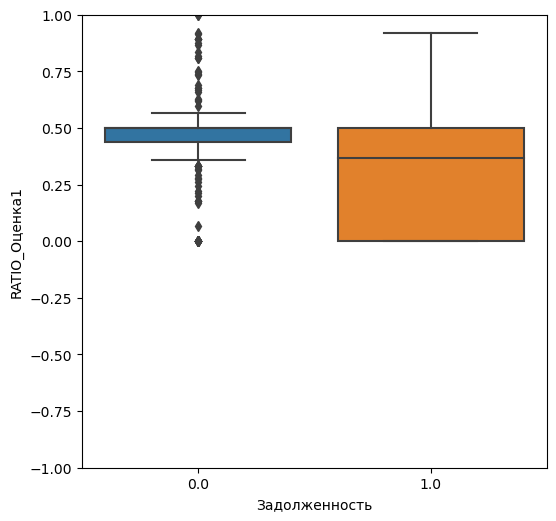

In [36]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
p=sns.boxplot(y=features_current['RATIO_Оценка1'], x=features_current['Задолженность'])
p.set(ylim=(-1, 1));

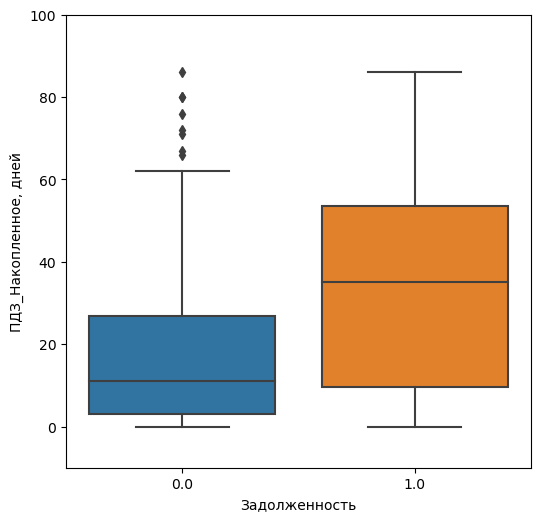

In [37]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
p=sns.boxplot(y=features_current['ПДЗ_Накопленное, дней'], x=features_current['Задолженность'])
p.set(ylim=(-10, 100));

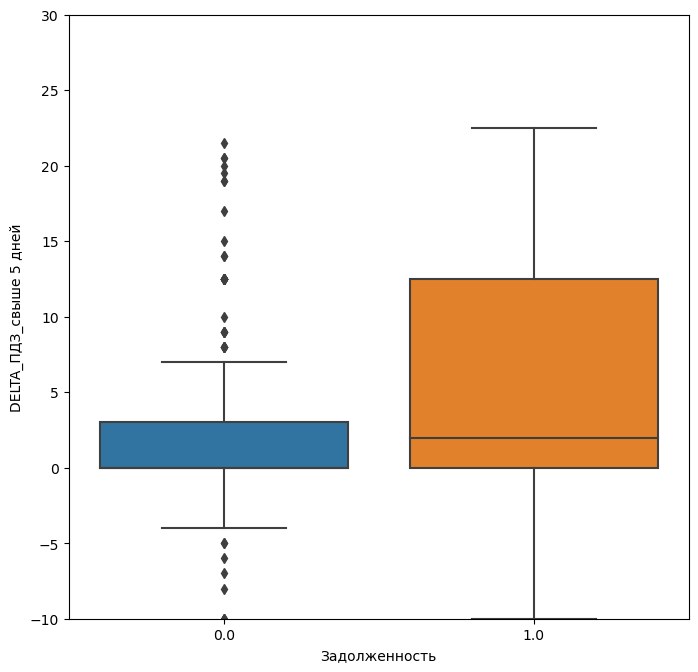

In [38]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_current['DELTA_ПДЗ_свыше 5 дней'], x=features_current['Задолженность'])
p.set(ylim=(-10, 30));

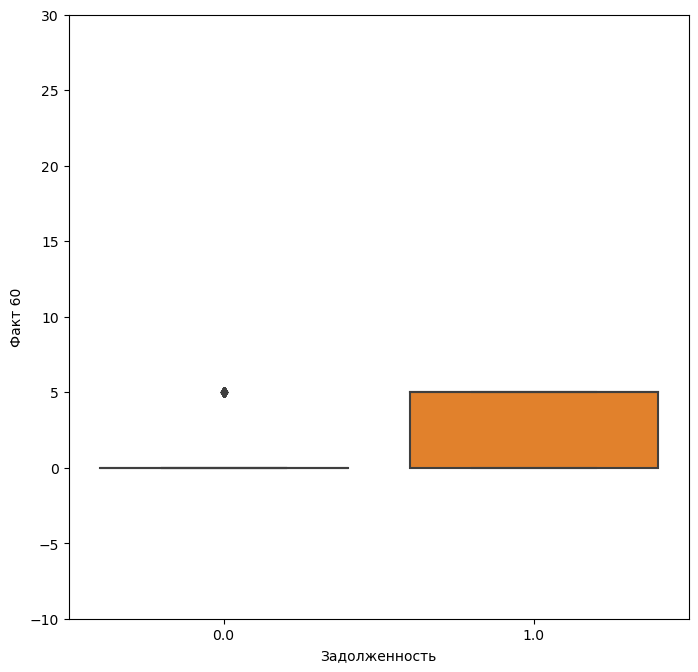

In [39]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_current['Факт 60'], x=features_current['Задолженность'])
p.set(ylim=(-10, 30));

Для существующих клиентов данные по прошлым задолженностям играют важную роль в прогнозировании факта возникновения задолжености.

Посмотрим на признаки для новых клиентов:

	FI
DELTA_Себестоимость продаж, RUB	5.274
2020Приход_Расход, %	4.835
2020_Итого_Активы, руб.	4.273
AV_Дебиторская задолженность, RUB	4.245
2019_Итого_Оборотные_активы, руб.	4.244

In [40]:
features_new['Задолженность']=target

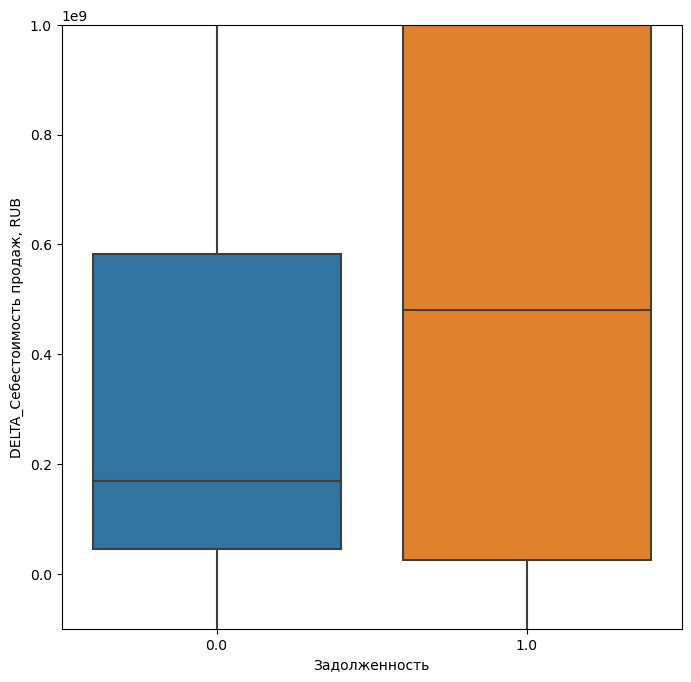

In [58]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_new['DELTA_Себестоимость продаж, RUB'], x=features_new['Задолженность'])
p.set(ylim=(-10**8, 10**9));

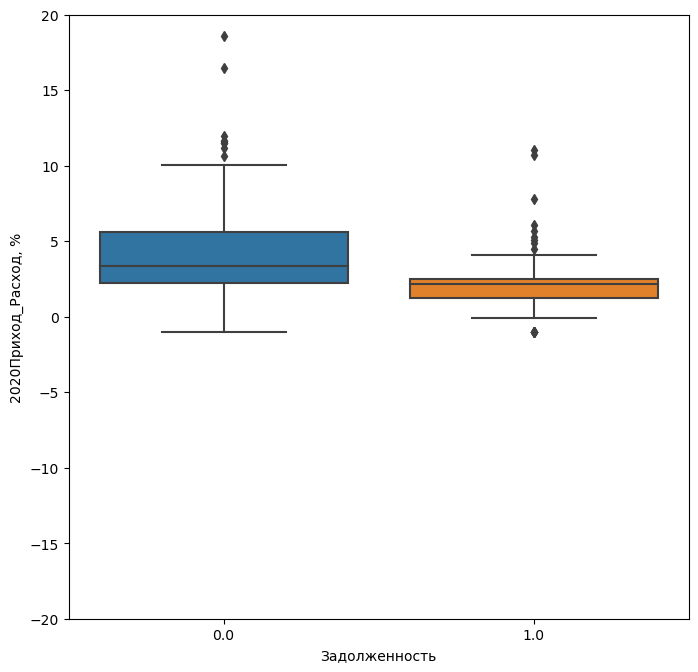

In [66]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_new['2020Приход_Расход, %'], x=features_new['Задолженность'])
p.set(ylim=(-20, 20));

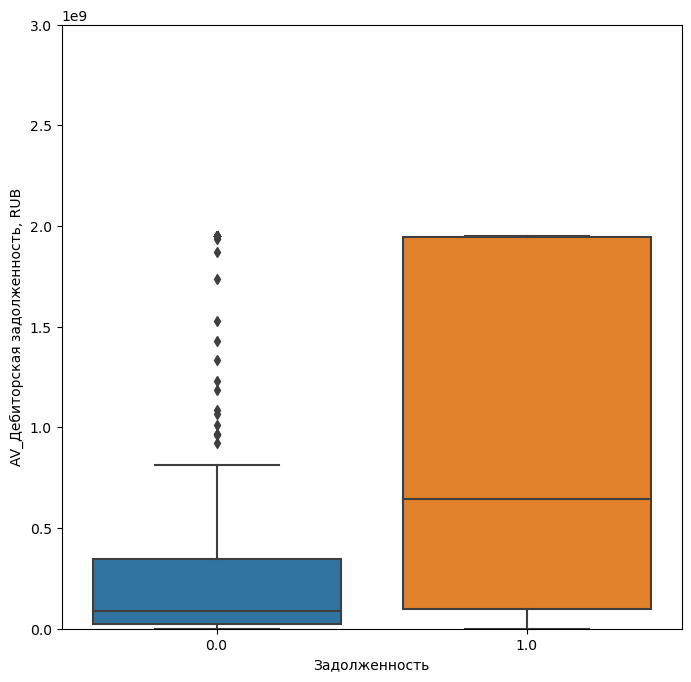

In [54]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
p=sns.boxplot(y=features_new['AV_Дебиторская задолженность, RUB'], x=features_new['Задолженность'])
p.set(ylim=(0, 0.3*10**10));